In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
df_train = pd.read_csv('./tweet-sentiment-extraction/train.csv')
df_test = pd.read_csv('./tweet-sentiment-extraction/test.csv')
df_train.head(1000)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
995,7c7a445b8d,"I am twittering, LIKE A BOSS. Thanks Savvv",Thanks Savvv,positive
996,fe6301dd3a,my sleep pattern is screwed i need to try and...,my sleep pattern is screwed,positive
997,fd98097a71,Since the demise of Woolworths it isn`t easy ...,isn`t easy to find,negative
998,a7b4ba7093,may the fourth be with you! happy star wars day,may the fourth be with you! happy star wars day,positive


In [3]:
df_test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [5]:
df_train.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11118


C:\Users\ariaq\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

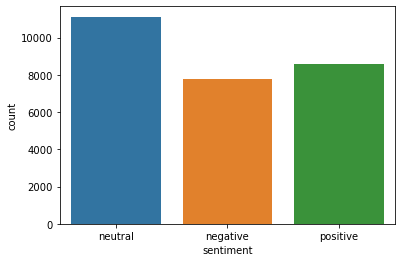

In [6]:
sns.countplot(df_train['sentiment'])

In [7]:
df_train[df_train['selected_text'].isnull()].index

Int64Index([314], dtype='int64')

In [8]:
df_test[df_test['text'].isnull()].index

Int64Index([], dtype='int64')

In [9]:
df_train.dropna(inplace=True)
len(df_train)

27480

In [10]:
x=df_train['selected_text']
y=df_train['sentiment']

In [11]:
x.isnull().sum()

0

In [12]:
y.isnull().sum()

0

## PREPROCESSIHG

In [13]:
from nltk.corpus import stopwords
import string

In [14]:
def text_process(mess):
    
    # Check characters to see if they are in punctuation
 
    nopunc = [char for char in mess if char not in string.punctuation ]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    word_seq=[word for word in nopunc.split() if word.lower() not in stopwords.words('english') and word.lower() not in ['https',':','/','.','com']]
    return word_seq

In [15]:
x=x.apply(text_process)
x

0                           [Id, responded, going]
1                                      [Sooo, SAD]
2                                       [bullying]
3                                   [leave, alone]
4                                           [Sons]
                           ...                    
27476                                       [lost]
27477                                [dont, force]
27478                                  [Yay, good]
27479                                      [worth]
27480    [flirting, going, ATG, smiles, Yay, hugs]
Name: selected_text, Length: 27480, dtype: object

## TOKENIZING

In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [60]:
max_len=100 #100, 200
max_words=10000
tokenizer=Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x)
sequences=tokenizer.texts_to_sequences(x)

text_data=pad_sequences(sequences,maxlen=max_len)

In [61]:
word_index=tokenizer.word_index

In [62]:
text_data.shape

(27480, 100)

In [63]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [64]:
encoder=LabelEncoder()
y=encoder.fit_transform(y)
label_data=np_utils.to_categorical(y)

In [65]:
# spliting data for valadation
x_train=text_data[:26000]
y_train=label_data[:26000]
x_test=text_data[26000:]
y_test=label_data[26000:]

## embedding using GLOVE word2vec

In [66]:
f=open('glove.840B.300d.txt',encoding="utf-8")
embeddings_index={}
for line in f:
    values=line.split(' ')
    word=values[0]
    coefs=np.asarray(values[1:],dtype='float32')
    embeddings_index[word]=coefs
f.close()

In [67]:
embedding_dim=300
embedding_matrix=np.zeros((max_words,embedding_dim))
for word,i in word_index.items():
    if i<max_words:
        embedding_vector=embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dropout,Dense,Bidirectional,LSTM,Flatten,Conv1D,MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

In [69]:
model=Sequential()
model.add(Embedding(max_words,embedding_dim,input_length=max_len))



model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Bidirectional(LSTM(64,return_sequences=True)))

model.add(LSTM(32))
model.add(Dropout(0.5))


model.add(Dense(32))


model.add(Dense(label_data.shape[1],activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [70]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable=False

In [71]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          3000000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 100, 256)         439296    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 100, 128)         164352    
 nal)                                                            
                                                                 
 lstm_8 (LSTM)               (None, 32)                20608     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 32)               

In [72]:
es=EarlyStopping(monitor='val_loss')

In [81]:
predictions=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=15)

Epoch 1/15
 94/813 [==>...........................] - ETA: 3:49 - loss: 0.1100 - accuracy: 0.9574

KeyboardInterrupt: 

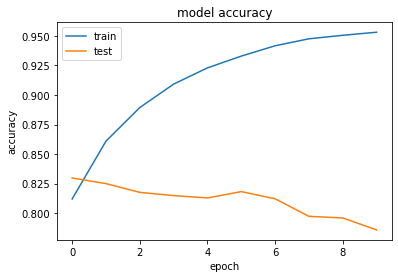

In [74]:
plt.plot(predictions.history['accuracy'])
plt.plot(predictions.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

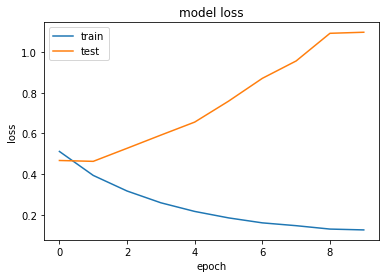

In [75]:
plt.plot(predictions.history['loss'])
plt.plot(predictions.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [76]:
scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', round(scores[0],2))
print('Test accuracy:', round(scores[1],2))

Test loss: 1.1
Test accuracy: 0.79


In [77]:
from sklearn.metrics import classification_report,confusion_matrix
def model_Evaluate(model,X_test,y_test):   #三分类
  # Predict values for Test dataset
    y_pred = model.predict(X_test)
  # Print the evaluation metrics for the dataset.
    y_test = np.argmax(y_test, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    print(classification_report(y_test, y_pred))
  # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Netrual','Positive']
    group_names = ['True Negative','False Netrual','False Positive', 'False Negative','True Netrual','False Positive','False Negative','False Netrual','True Positive']
    group_percentages = ['\n{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}{v2}' for v1, v2 in zip(group_names, group_percentages)]
  
    labels = np.asarray(labels).reshape(3,3)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [78]:
x_test

array([[   0,    0,    0, ...,    0,   32, 1566],
       [   0,    0,    0, ...,    0,  104,   39],
       [   0,    0,    0, ...,    0,    0,  996],
       ...,
       [   0,    0,    0, ...,    0,  118,    2],
       [   0,    0,    0, ...,    0,    0,  460],
       [   0,    0,    0, ..., 2334,  118,  581]])

In [79]:
y_pred = model.predict(x_test)
y_pred

array([[4.0203679e-01, 5.7866699e-03, 5.9217650e-01],
       [3.3370782e-02, 2.0456496e-03, 9.6458358e-01],
       [1.2617831e-01, 3.4531394e-03, 8.7036860e-01],
       ...,
       [5.2004340e-03, 2.2221108e-03, 9.9257749e-01],
       [2.3665828e-04, 1.0776093e-04, 9.9965560e-01],
       [5.3408148e-05, 3.3207685e-03, 9.9662590e-01]], dtype=float32)

              precision    recall  f1-score   support

           0       0.72      0.76      0.74       421
           1       0.82      0.75      0.78       600
           2       0.80      0.85      0.83       459

    accuracy                           0.79      1480
   macro avg       0.78      0.79      0.78      1480
weighted avg       0.79      0.79      0.79      1480



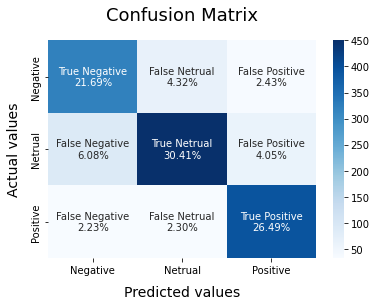

In [80]:
model_Evaluate(model, x_test, y_test)

In [38]:
test_feature=df_test['text']
test_feature=test_feature.apply(text_process)

In [39]:
max_len=100
max_words=20000
tokenizer=Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(test_feature)
test_sequences=tokenizer.texts_to_sequences(test_feature)

test_data=pad_sequences(test_sequences,maxlen=max_len)

In [40]:
len(df_test['sentiment'])

3534

In [41]:
test_label=df_test['sentiment']
test_label=encoder.fit_transform(test_label)
test_label=np_utils.to_categorical(test_label)
word_index=tokenizer.word_index

In [42]:
embedding_dim=300
embedding_matrix=np.zeros((max_words,embedding_dim))
for word,i in word_index.items():
    if i<max_words:
        embedding_vector=embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector

In [43]:
model=Sequential()
model.add(Embedding(max_words,embedding_dim,input_length=max_len))



model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Bidirectional(LSTM(64,return_sequences=True)))

model.add(LSTM(32))
model.add(Dropout(0.5))


model.add(Dense(32))



model.add(Dense(label_data.shape[1],activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [44]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable=False

In [45]:
test_predictions = np.argmax(model.predict(x_test), axis=-1)

ValueError: in user code:

    File "C:\Users\ariaq\anaconda3\lib\site-packages\keras\engine\training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\ariaq\anaconda3\lib\site-packages\keras\engine\training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ariaq\anaconda3\lib\site-packages\keras\engine\training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\ariaq\anaconda3\lib\site-packages\keras\engine\training.py", line 1572, in predict_step
        return self(x, training=False)
    File "C:\Users\ariaq\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\ariaq\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 100), found shape=(None, 200)


In [ ]:
test_predictions.shape

In [ ]:
test_predictions=encoder.inverse_transform(test_predictions)

In [ ]:
test_predictions

In [ ]:
submission=pd.read_csv('./tweet-sentiment-extraction/sample_submission.csv')
submission.head()

In [ ]:
submission['selected_text']=test_feature
submission.to_csv('submission.csv')